# The idea of this project is to compare the implementation of a CNN architecture and a Reinforcement Learning architecture for a classification problem, more precisely, we are trying to learn how to play the Lunar Landing videogame (Atari 1979). Moreover, we implement two strategies for the CNN architecture, the first one uses a single frame as input and the second one uses five, with the intention of bringing variables to the equation such as speed, acceleration and so on. Enjoy the lift :)

In [1]:
import numpy as np
import pandas as pd
import keras
import cv2
import os
import glob
import re
import sys
import io
from imgaug import augmenters as iaa
import imgaug as ia
import skimage
from matplotlib import pyplot as plt
import tqdm
import random

from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from sklearn.utils import shuffle

from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.callbacks import ModelCheckpoint

import gym
from keras.models import Sequential
from keras.optimizers import Adam
from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

import lunar_lander_ml_images_player as ll

Using TensorFlow backend.


## First off we need to define a function for the preprocessing of our pictures, in our case, we will be only resizing the pictures, converting to grayscale and maybe mixed them in groups of 5 frames, then saving them on disk

In [1]:
# sort files in correct order
def sorted_aphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

def prepare_images(path_read, path_write, mix=False):
    """1) Convert to grayscale, 2) Shrink, 3) Prepare groups of 5 frames??
    path_read: string, path to images to prepare
    path_write: string, path to write new transformed images
    mix: boolean, mixes a sequence of 5 images if true
    """
    HEIGHT = 84
    WIDTH = 84
    
    filenames = sorted_aphanumeric(os.listdir(path_read))
    
    for i, filename in enumerate(tqdm.tqdm(filenames)):
        # image in color
        if not mix:
            # parameter in imread: #1 = color, #0 = gray, #-1 = unchanged (alpha)
            image = cv2.imread(os.path.join(path_read,filename), 1) 
            resized_image = cv2.resize(image, (WIDTH, HEIGTH))
            cv2.imwrite(os.path.join(path_write, filename), resized_image)
        else:
            mixed_image = np.zeros(shape=(WIDTH,HEIGHT), dtype=np.uint8)
            try:
                slice_ = filenames[i:i+5]
            except:
                slice_ = filenames[i]*5
            for j, slicedfile in enumerate(slice_):
                # read image in gray scale
                image = cv2.imread(os.path.join(path_read,slicedfile), 0) 
                # resize it
                resized_image = cv2.resize(image, (WIDTH, HEIGHT))
                # add it to create sequence effect
                mixed_image += resized_image
            cv2.imwrite(os.path.join(path_write, filename), mixed_image)          

In [152]:
prepare_images('LunarLanderFramesPart1/', 'transformed-frames')

100%|████████████████████████████████████████████████████████████████████████████| 63671/63671 [14:40<00:00, 89.13it/s]


## Transformation is complete, now, we will get the action related to each picture:

In [9]:
def get_actions(path_read, path_write):
    """Extract actions from file names (last digit before the extension)
        0 = None
        1 = Up
        2 = Left
        3 = Right
    """
    filenames = os.listdir(path_read)
    # extract action
    actions = [filename[-6] for filename in filenames]
    pd.DataFrame(actions, columns=['actions']).to_csv(path_write, index=False)
    return actions

In [154]:
if not os.path.isfile('csv/actions.csv'):
    get_actions('LunarLanderFramesPart1/', 'csv/actions.csv')

## Once we extract our actions, we proceed to check the distribution of the classes

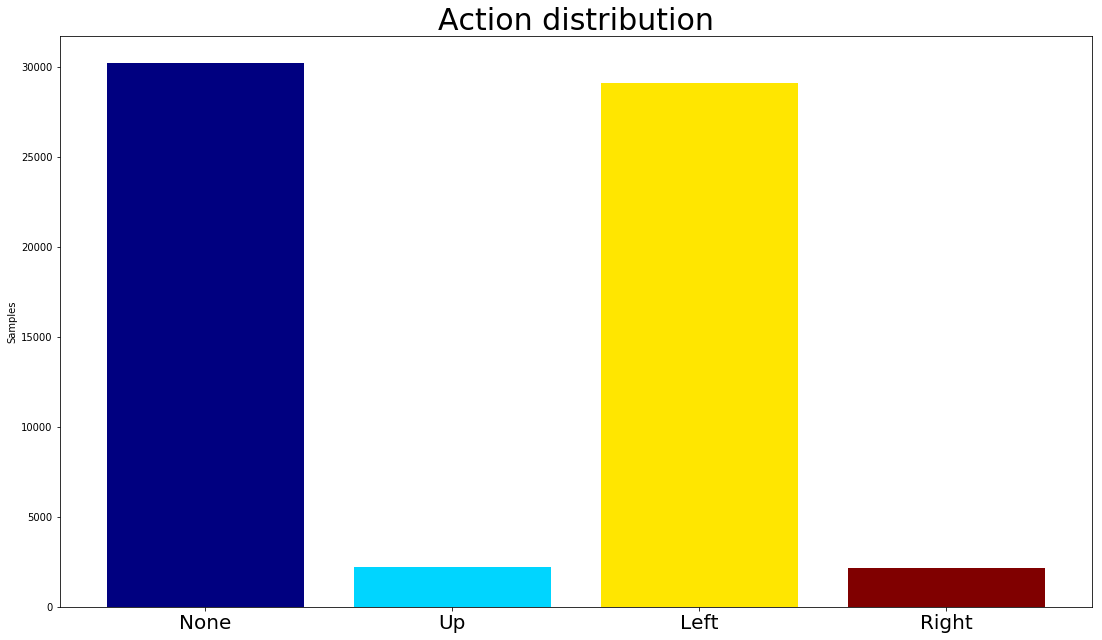

In [37]:
actions = pd.read_csv('csv/actions.csv')
count = actions.groupby('actions')['actions'].count()

n = len(count)
colors = plt.cm.jet(np.linspace(0, 1, n))

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
plt.ylabel('Samples')
plt.bar(['None', "Up", "Left", "Right"], count, color=colors)
plt.xticks(fontsize =20)
plt.title("Action distribution", fontsize=30)
plt.show()

## Our classes are highly imbalanced, to fix this we will create new samples, these new samples will not be an exact copy of current frames (as implemented by the upsampling techniques), but instead will be an augmented version of them. First we calculate the imbalance ratio (i.e. if majority class has 10 samples, ratio= (10/samples from other classes)-1; then we use this ratio to define how many copies will be created from minority classes. 

In [5]:
def calculate_imbalance(path_read):
    """ Calculate samples of class with max samples, then compute the ratio
    between this value and the difference of the rest of the classes. Returns a dictionary {'class': ratio difference}
    """
    imbalance = {}
    filenames = os.listdir(path_read)
    # extract action
    actions = [filename[-6] for filename in filenames]
    # get number of samples of majority class
    count = pd.DataFrame(actions, columns=['actions']).groupby('actions')['actions'].count()
    max_ = count.max()
    #for each action
    for index in count.index:
        # how many times to reach max_ samples?
        imbalance[index] =  (max_  // count[index]) - 1
    print(imbalance)
    return imbalance

def fix_class_imbalance(path_read, path_write):
    """Classes are very unbalanced, fix them by augmenting the under represented classes
    path_read: string, path to images
    unbalanced: list, numeric value corresponding to unbalanced classes [0 = None, 1 = Up, 2 = Left, 3 = Right]
    """
    images = os.listdir(path_read)
    # read an image to extract image dimensions
    im = cv2.imread(os.path.join(path_read,images[0]), 1)# parameter in imread: #1 = color, #0 = gray, #-1 = unchanged (alpha)
    width, height, channels = im.shape
    
    # which classes are imbalanced?
    print("Calculating imbalances ratio...")
    imbalance = calculate_imbalance(path_read)
    imbalanced_filenames = []
    for i, image in enumerate(images):
        # select those files from imbalanced classes (all classes expect majority class)
        if imbalance[image[-6]] != 0:
            imbalanced_filenames.append(image)
    
    # multiply list by deficit ratio (imbalance)
    filtered_by_ratio = []
    print("Multiplying filenames by ratio imbalance...")
    for key in imbalance:
        # select files from same class
        filtered = [file for file in imbalanced_filenames if key +'.jpeg' in file]
        # append files times deficit value
        filtered_by_ratio.append(filtered*imbalance[key])
    # list of lists to a single list
    filtered_and_sorted = [item for sublist in filtered_by_ratio for item in sublist]
    
    # define numpy array place holder
    np_images = np.zeros(shape=(len(filtered_and_sorted),width,height, channels), dtype=np.uint8)
    print(np_images.shape)

    # read imbalanced files and save then in np array placeholder
    print("Reading images to transform...")
    for i, image in enumerate(filtered_and_sorted):
        np_images[i] = cv2.imread(os.path.join(path_read, image), 1) # parameter in imread: #1 = color, #0 = gray, #-1 = unchanged (alpha)
        
    ia.seed(1)
    # define transformations
    seq = iaa.Sequential(
        [
            iaa.Sometimes(0.2,iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5))),
            iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
        ], random_order=True) # apply augmenters in random order
    
    print("Starting transformation...")
    images_aug = seq.augment_images(np_images)

    # save augmented images
    counter = 0
    print("Saving transformed files ...")
    for i, filename in enumerate(tqdm.tqdm(filtered_and_sorted)):
        if i > 0:
            # next file belongs to different class?
            if filtered_and_sorted[i-1][-6] != filename[-6]:
                counter = 0
        cv2.imwrite(path_write + str(counter).zfill(5) + '_' + filename[-6] + '.jpeg', images_aug[i])
        counter += 1

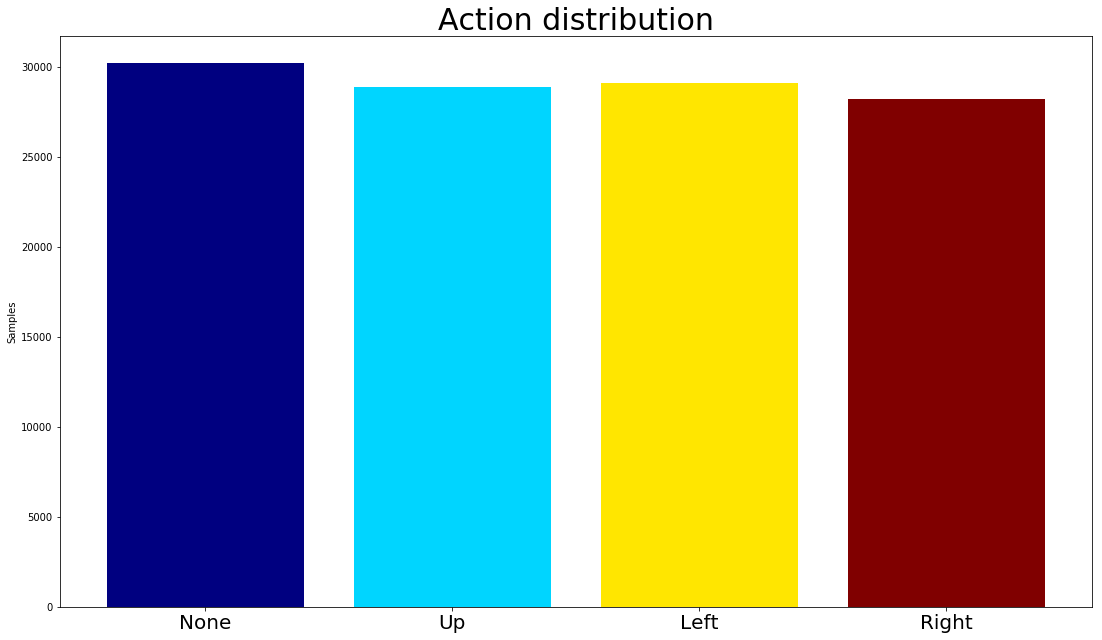

In [36]:
if not os.path.isfile('csv/actions_balanced.csv'):
    fix_class_imbalance('transformed-frames/', 'transformed-frames/')
    
if not os.path.isfile('csv/actions_balanced.csv'):
        get_actions('transformed-frames/', 'csv/actions_balanced.csv')
        actions = pd.read_csv('csv/actions_balanced.csv')
        count = actions.groupby('actions')['actions'].count()

        n = len(count)
        colors = plt.cm.jet(np.linspace(0, 1, n))

        fig = plt.figure()
        fig.set_size_inches(18.5, 10.5)
        plt.bar(['None', "Up", "Left", "Right"], count, color=colors)
        plt.ylabel('Samples')
        plt.xticks(fontsize =20)
        plt.title("Action distribution", fontsize=30)
        plt.show()

## We now have a more even distribution. Images have been saved on disk. Now, it's time to split and prepare our data for training.

In [5]:
def train_val_test(path_read_x, path_read_y):
    filenames = os.listdir(path_read_x)
    target = pd.read_csv(path_read_y)
    
    # here the X splits are filenames, y splits are actual class numbers
    X_train_val, X_test, y_train_val, y_test = train_test_split(filenames, target, random_state=0, test_size = 0.30, train_size = 0.7)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=0, test_size = 0.20, train_size = 0.8)
    
    # first image for placeholder
    image = cv2.imread(os.path.join(path_read_x,filenames[0]), 1)
    width, height, channel = image.shape
    
    # define placeholders
    X_train_np = np.zeros(shape = (len(X_train), width, height, channel ), dtype=np.uint8)
    X_val_np = np.zeros(shape = (len(X_val), width, height, channel ), dtype=np.uint8)
    X_test_np = np.zeros(shape = (len(X_test), width, height, channel), dtype=np.uint8)

    # fill up the placeholders
    for i, image in enumerate(tqdm.tqdm(X_train)):
        X_train_np[i] = cv2.imread(os.path.join(path_read_x,image), 1)
    
    for i, image in enumerate(tqdm.tqdm(X_val)):
        X_val_np[i] = cv2.imread(os.path.join(path_read_x,image), 1)
    
    for i, image in enumerate(tqdm.tqdm(X_test)):
        X_test_np[i] = cv2.imread(os.path.join(path_read_x,image), 1)


    # Convert class vectors to binary class matrices.
    num_classes = 4
    
    y_train_wide = keras.utils.to_categorical(y_train, num_classes)
    y_val_wide = keras.utils.to_categorical(y_val, num_classes)
    y_test_wide = keras.utils.to_categorical(y_test, num_classes)
    
    classes_num_label = dict()

    for idx, lbl in enumerate([0, 1, 2, 3]):
        classes_num_label[idx] = lbl
    
    return X_train_np, X_val_np, X_test_np, y_train_wide, y_val_wide, y_test_wide, y_train, y_val, y_test

In [6]:
X_train, X_val, X_test, y_train_w, y_val_w, y_test_w, y_train, y_val, y_test = train_val_test('transformed-frames/', 'csv/actions_balanced.csv')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34902/34902 [03:00<00:00, 193.83it/s]


## Split and preprocessing is finished, now let's preview some images from our training set

In [18]:
def preview_images():
    fig = plt.figure()
    fig.set_size_inches(18.5, 10.5)
    fig.suptitle("Preview images", fontsize=20)
    
    nrow = 3
    ncol = 3
    action = ["none","up","left","right"]
    for i in range(1, 10):
        index = np.argwhere(y_train_w[i]==1)[0][0]
        ax = plt.subplot("33"+str(i))
        ax.set_title(action[index], fontsize=15)
        ax.imshow(X_train[i])

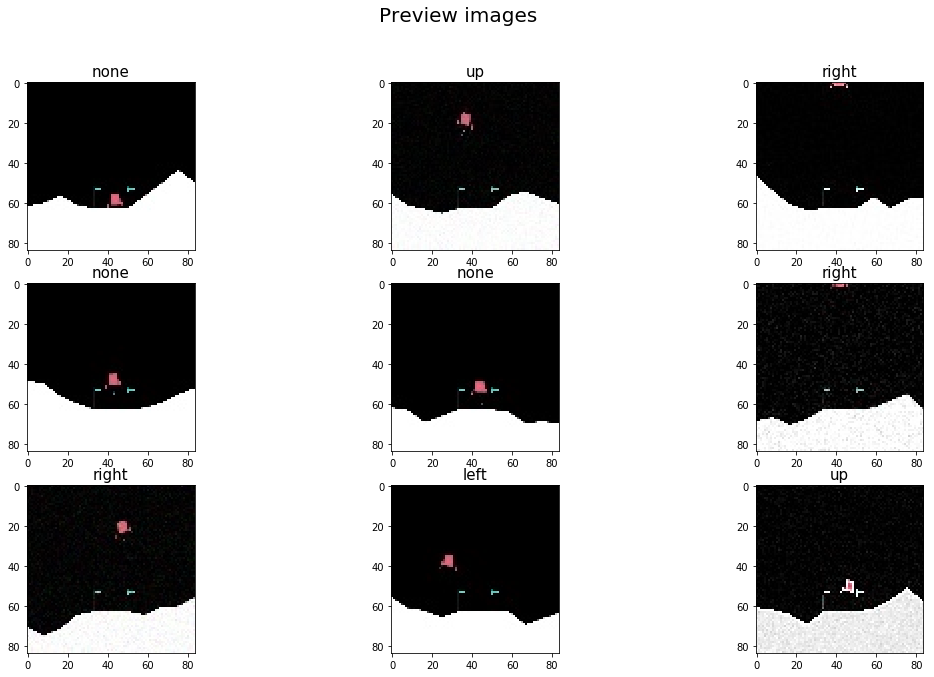

In [165]:
preview_images()

## Now, the cool part of the process, loading and building the VGG16 network. As we want to keep what the network has already learnt, we will freeze the weights up until the 17th layer, from there on we will train a dense layer with the features produced by feeding of our images through the frozen weights of VGG16.

In [10]:
def build_VGG16(neurons_lastlayer=[100,50], activation='relu', dropout=0.2):
    """Loads the VGG16 network and modifies it so that a new dense layer on top is trainable
    """
    NUM_OF_CLASSES = 4
    
    width, height, channel = X_train[0].shape
    shape = (width, height, channel)
    # build the VGG16 network
    # network requires input shape to be a tuple of three numbers, channel numbers have to be three as well.
    vgg16_model = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape = shape)
    display(vgg16_model.summary())
    vgg16_last_layer = vgg16_model.output

    # build a classifier model to put on top of the VGG16 model
    x1 = Flatten()(vgg16_last_layer)
    x2 = Dense(neurons_lastlayer[0], activation=activation)(x1)
    x3 = Dropout(dropout)(x2)
    x4 = Dense(neurons_lastlayer[1], activation=activation)(x3)
    x5 = Dropout(dropout)(x4)
    final_layer = Dense(NUM_OF_CLASSES, activation = 'softmax')(x5)

    # Assemble the full model out of both parts
    full_model = keras.Model(vgg16_model.input, final_layer)

    # set the first 17 layers (up to the last conv block) to non-trainable (weights will not be updated)
    for layer in full_model.layers[:17]:
        layer.trainable = False

    # compile the model with a SGD/momentum optimizer
    # and a very slow learning rate.
    full_model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.SGD(lr=1e-4, momentum=0.9),
                  metrics=['accuracy'])

    full_model.summary()
    return full_model
    

In [11]:
full_model = build_VGG16()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 84, 84, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 84, 84, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 84, 84, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 42, 42, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 42, 42, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 42, 42, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 21, 21, 128)       0         
__________

None

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 84, 84, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 84, 84, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 84, 84, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 42, 42, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 42, 42, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 42, 42, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 21, 21, 128)       0         
__________

## The model is loaded and ready to be trained. Now, we setup fitting scheme, we will use checkpoints to callback to the best set of parameters once training is done.

In [12]:
batch_size = 128
epochs = 25

# Set up the callback to save the best model based on validaion data - notebook 2.2 needs to be run first.
best_weights_filepath = 'weights/best_weights.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_loss", save_best_only=True, save_weights_only=False)

history = full_model.fit(X_train, y_train_w, batch_size=batch_size, epochs=epochs, 
                         verbose = 2, validation_data=(X_val, y_val_w), shuffle=True, callbacks=[mcp])

#reload best weights
full_model.load_weights(best_weights_filepath)

Train on 65149 samples, validate on 16288 samples
Epoch 1/25
 - 92s - loss: 0.5332 - acc: 0.7845 - val_loss: 0.3364 - val_acc: 0.8438
Epoch 2/25
 - 91s - loss: 0.3708 - acc: 0.8284 - val_loss: 0.3041 - val_acc: 0.8615
Epoch 3/25
 - 91s - loss: 0.3381 - acc: 0.8443 - val_loss: 0.2896 - val_acc: 0.8707
Epoch 4/25
 - 91s - loss: 0.3174 - acc: 0.8551 - val_loss: 0.2693 - val_acc: 0.8795
Epoch 5/25
 - 91s - loss: 0.3017 - acc: 0.8631 - val_loss: 0.2561 - val_acc: 0.8865
Epoch 6/25
 - 91s - loss: 0.2895 - acc: 0.8690 - val_loss: 0.2507 - val_acc: 0.8882
Epoch 7/25
 - 91s - loss: 0.2798 - acc: 0.8736 - val_loss: 0.2395 - val_acc: 0.8948
Epoch 8/25
 - 91s - loss: 0.2723 - acc: 0.8775 - val_loss: 0.2343 - val_acc: 0.8985
Epoch 9/25
 - 91s - loss: 0.2635 - acc: 0.8817 - val_loss: 0.2317 - val_acc: 0.8979
Epoch 10/25
 - 91s - loss: 0.2572 - acc: 0.8853 - val_loss: 0.2227 - val_acc: 0.9029
Epoch 11/25
 - 91s - loss: 0.2503 - acc: 0.8882 - val_loss: 0.2199 - val_acc: 0.9040
Epoch 12/25
 - 91s - los

## Training is finished, let's look at the loss graphs for the training and validation sets.

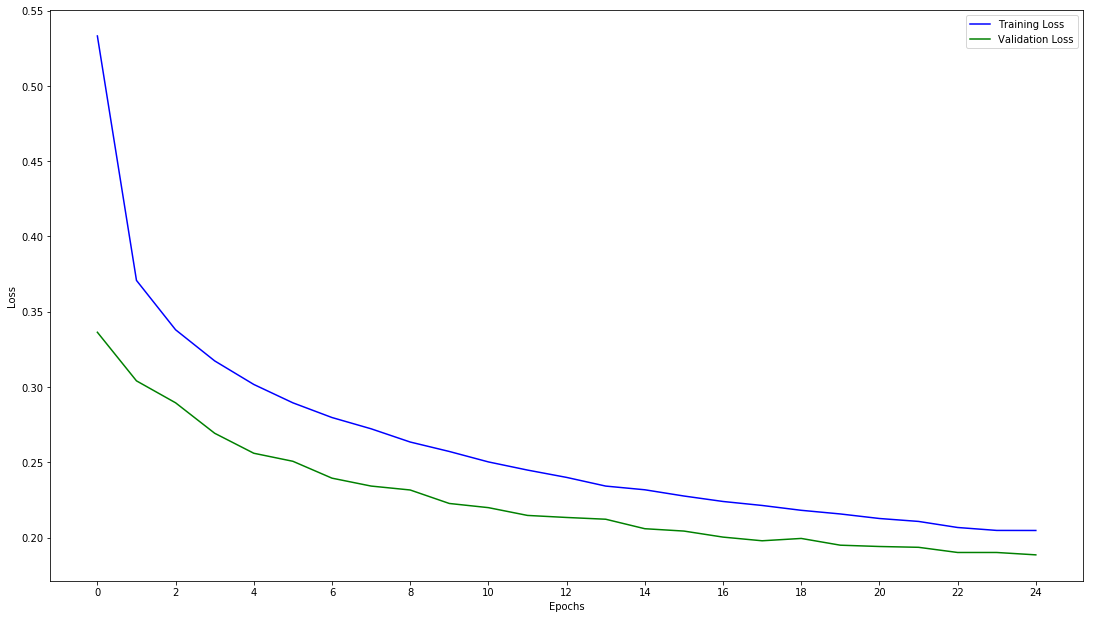

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

## But, how well did our model do? Not so great, class 2 is too low on precision, we can see the miss classification in our confussion matrix, it could not learn to differentiate well between class 0 and class 2.

In [14]:
# Make a set of predictions for the validation data
pred = np.argmax(full_model.predict(X_val),axis=1)

# Print performance details
print(metrics.classification_report(y_val, pred))

print("Confusion matrix")
print(metrics.confusion_matrix(y_val, pred))

              precision    recall  f1-score   support

           0       0.87      0.64      0.74      4139
           1       0.95      0.89      0.92      4041
           2       0.67      0.93      0.78      4130
           3       0.95      0.89      0.92      3978

   micro avg       0.84      0.84      0.84     16288
   macro avg       0.86      0.84      0.84     16288
weighted avg       0.86      0.84      0.84     16288

Confusion matrix
[[2659   18 1443   19]
 [  74 3585  219  163]
 [ 272   16 3835    7]
 [  58  144  249 3527]]


## Now, let's see how we do in our test set

In [15]:
# Make a set of predictions for the validation data
pred = np.argmax(full_model.predict(X_test),axis=1)

# Print performance details
print(metrics.classification_report(y_test, pred))

print("Confusion matrix")
print(metrics.confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

           0       0.87      0.64      0.74      9065
           1       0.95      0.89      0.92      8626
           2       0.67      0.93      0.78      8788
           3       0.95      0.89      0.92      8423

   micro avg       0.84      0.84      0.84     34902
   macro avg       0.86      0.84      0.84     34902
weighted avg       0.86      0.84      0.84     34902

Confusion matrix
[[5824   46 3156   39]
 [ 177 7695  444  310]
 [ 533   40 8200   15]
 [ 152  286  524 7461]]


## Some examples of good and bad predictions:

In [16]:
def preview_results(mode='correct'):
    fig = plt.figure()
    fig.set_size_inches(18.5, 10.5)
    nrow = 3
    ncol = 3
    action = ["none","up","left","right"]
    
    if mode == 'correct':
    
        correct_prediction = []
        index_correct = []
        i = 0
    
        while (len(correct_prediction)<10):
            if pred[i] == y_test.values[i][0]:
                # class
                correct_prediction.append(y_test.values[i][0])
                # index of class stored
                index_correct.append(i)
            i += 1
    
    if mode == 'incorrect':
    
        correct_prediction = []
        index_correct = []
        i = 0
    
        while (len(correct_prediction)<10):
            if pred[i] != y_test.values[i][0]:
                # class
                correct_prediction.append(y_test.values[i][0])
                # index of class stored
                index_correct.append(i)
            i += 1
        
    for i in range(1,10):
        index = correct_prediction[i]
        ax = plt.subplot("33"+str(i))
        ax.set_title(action[index], fontsize=15)
        ax.imshow(X_test[index_correct[i]])

    fig.suptitle("Preview "+ mode +" predictions", fontsize=20)

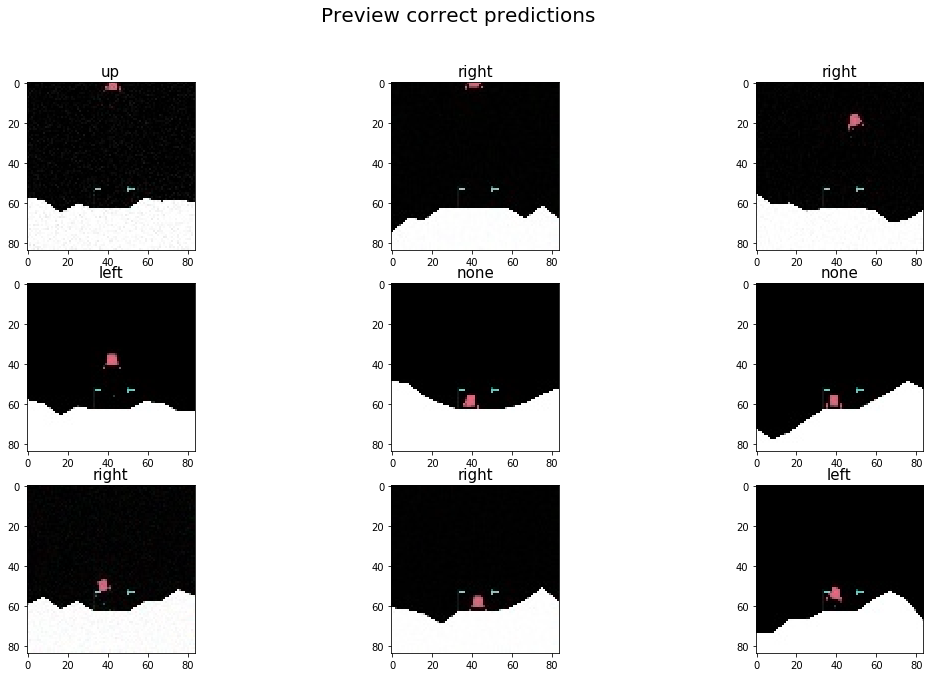

In [17]:
preview_results('correct')

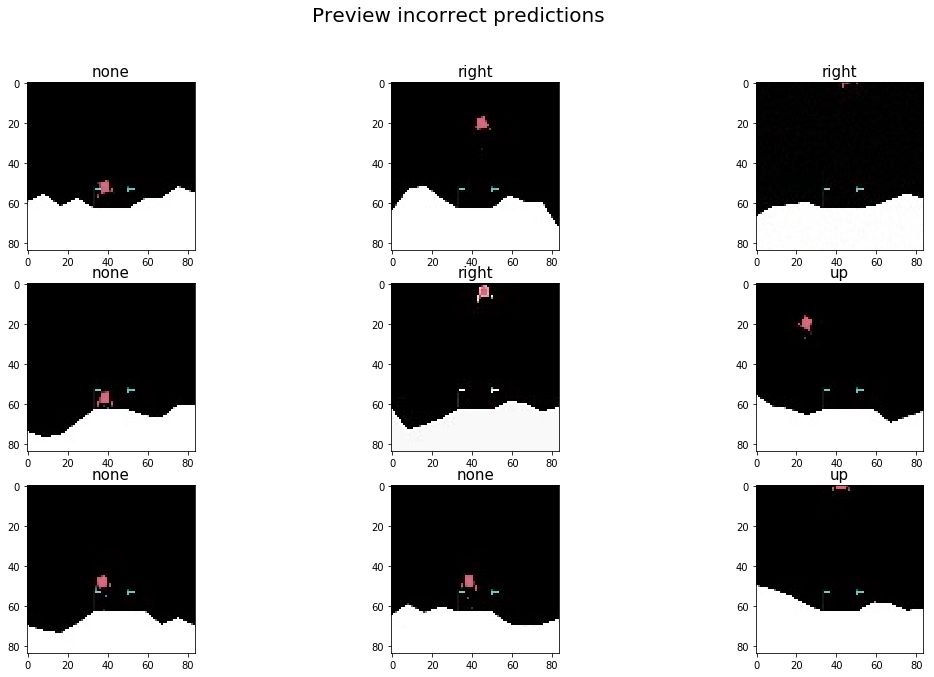

In [18]:
preview_results('incorrect')

# WHAT IF...?


# What if instead of using a single frame we use a sequence of frames? Maybe the model can capture variables such as speed or acceleration. Let's try this strategy.

In [ ]:
# read images in gray scale and resize them
# mix five frames together (add the matrix values)
    # each mixed sequence will have a class name equals to that of the main one.
# once mixing is finished, solve the class imbalance issue.

## First, we prepare our images: transform them to grayscale, resize them to 84x84 and mixed a sequence of 5 frames together

In [3]:
prepare_images('LunarLanderFramesPart1/', 'mixed/', True)

100%|████████████████████████████████████████████████████████████████████████████| 63671/63671 [26:05<00:00, 40.68it/s]


## We repeat the process as in the previous strategy:
### Fix the class imbalance, split the data set into train, eval and test sets and train the model.

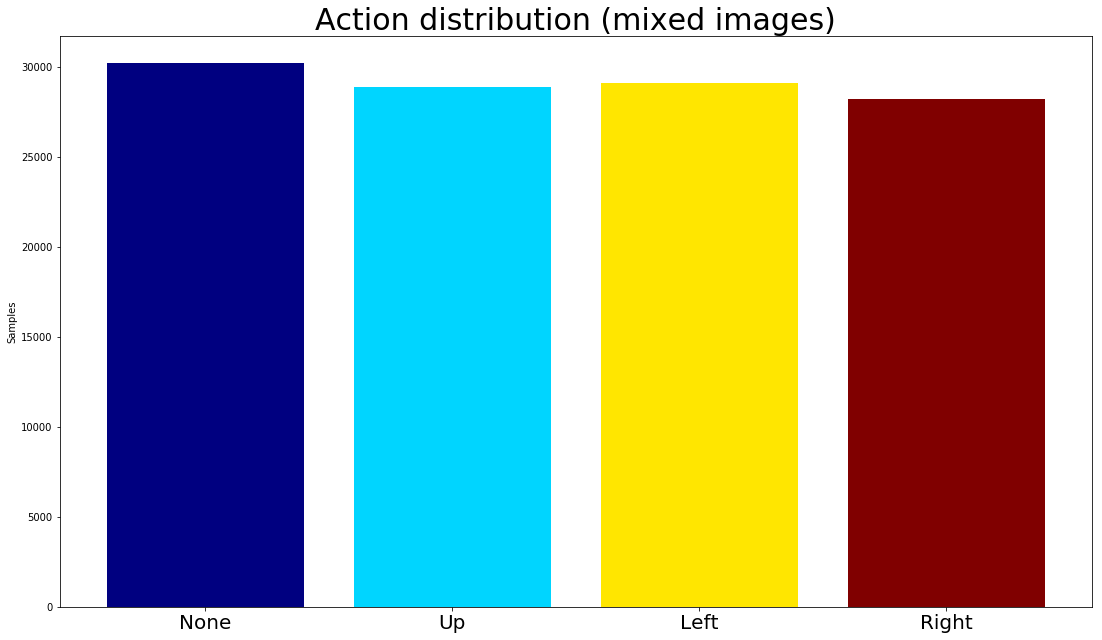

In [13]:
if not os.path.isfile('csv/actions_mixed_balanced.csv'):
    fix_class_imbalance('mixed/', 'mixed/')
    
if not os.path.isfile('csv/actions_mixed_balanced.csv'):
    get_actions('mixed/', 'csv/actions_mixed_balanced.csv')
    actions = pd.read_csv('csv/actions_mixed_balanced.csv')
    count = actions.groupby('actions')['actions'].count()

    n = len(count)
    colors = plt.cm.jet(np.linspace(0, 1, n))

    fig = plt.figure()
    fig.set_size_inches(18.5, 10.5)
    plt.bar(['None', "Up", "Left", "Right"], count, color=colors)
    plt.ylabel('Samples')
    plt.xticks(fontsize =20)
    plt.title("Action distribution (mixed images)", fontsize=30)
    plt.show()

In [20]:
X_train, X_val, X_test, y_train_w, y_val_w, y_test_w, y_train, y_val, y_test = train_val_test('mixed/', 'csv/actions_mixed_balanced.csv')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34902/34902 [08:19<00:00, 69.89it/s]


## Now, let's take a look to the resulting images from our training set

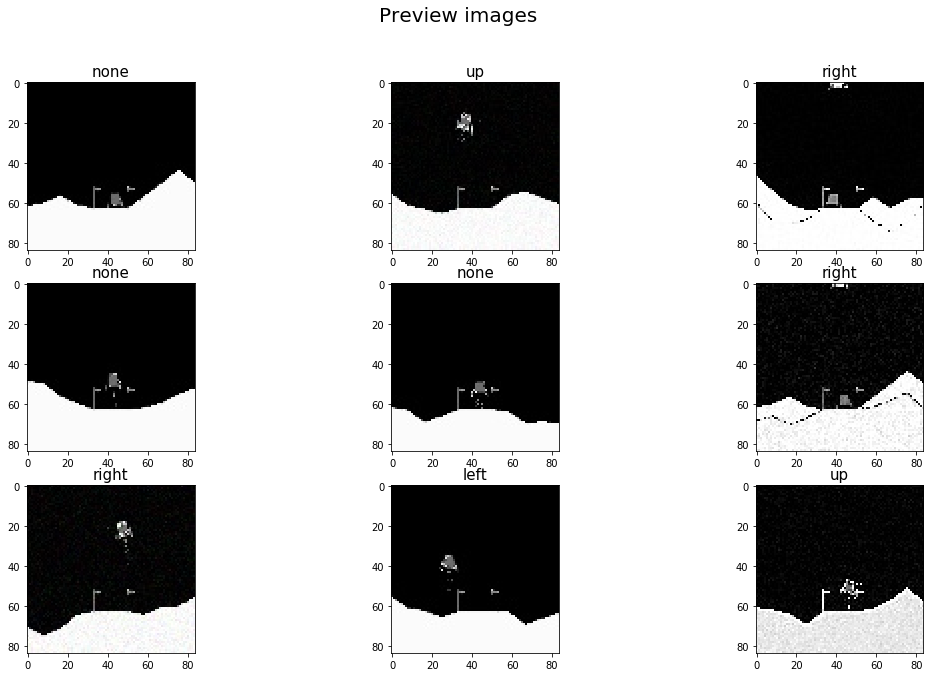

In [19]:
preview_images()

## Build a new model and set it up for training.

In [21]:
full_model_mixed = build_VGG16()

batch_size = 128
epochs = 25

# Set up the callback to save the best model based on validaion data - notebook 2.2 needs to be run first.
best_weights_filepath = 'weights/best_weights_mixed.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_loss", save_best_only=True, save_weights_only=False)

history = full_model_mixed.fit(X_train, y_train_w, batch_size=batch_size, epochs=epochs, 
                         verbose = 2, validation_data=(X_val, y_val_w), shuffle=True, callbacks=[mcp])

#reload best weights
full_model_mixed.load_weights(best_weights_filepath)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 84, 84, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 84, 84, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 84, 84, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 42, 42, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 42, 42, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 42, 42, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 21, 21, 128)       0         
__________

None

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 84, 84, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 84, 84, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 84, 84, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 42, 42, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 42, 42, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 42, 42, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 21, 21, 128)       0         
__________

## Training is finished, let's take a look at the evolution of the losses

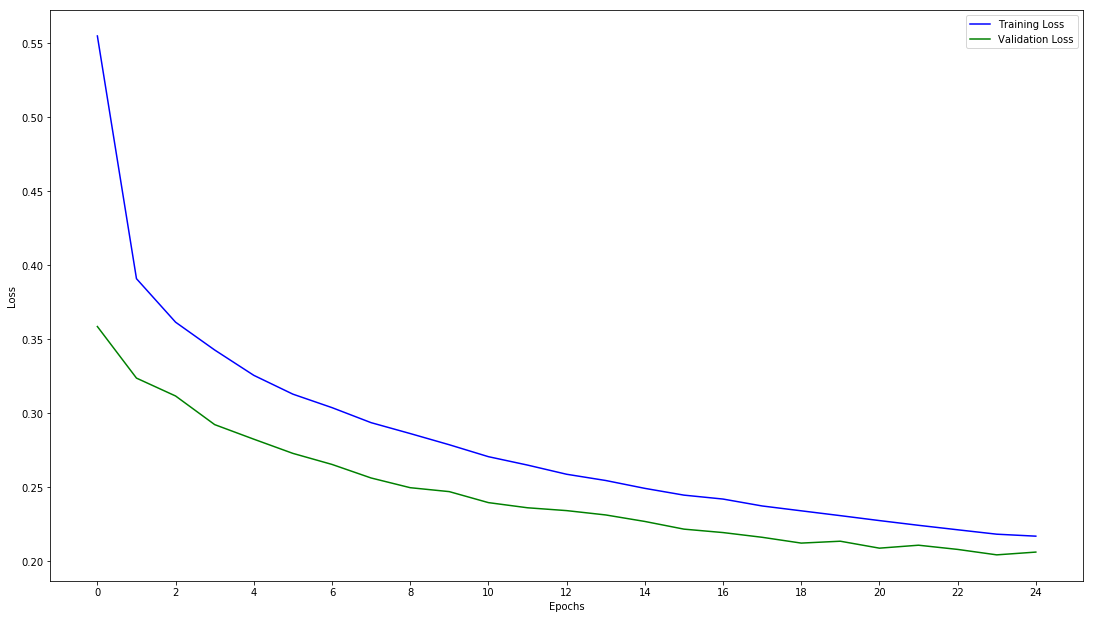

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

In [23]:
# Make a set of predictions for the validation data
pred = np.argmax(full_model_mixed.predict(X_val),axis=1)

# Print performance details
print(metrics.classification_report(y_val, pred))

print("Confusion matrix")
print(metrics.confusion_matrix(y_val, pred))

              precision    recall  f1-score   support

           0       0.83      0.64      0.73      4139
           1       0.93      0.88      0.91      4041
           2       0.66      0.91      0.77      4130
           3       0.95      0.87      0.90      3978

   micro avg       0.82      0.82      0.82     16288
   macro avg       0.84      0.82      0.83     16288
weighted avg       0.84      0.82      0.82     16288

Confusion matrix
[[2666   36 1397   40]
 [  93 3560  247  141]
 [ 351   18 3745   16]
 [  83  200  254 3441]]


In [24]:
# Make a set of predictions for the test data
pred = np.argmax(full_model_mixed.predict(X_test),axis=1)

# Print performance details
print(metrics.classification_report(y_test, pred))

print("Confusion matrix")
print(metrics.confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

           0       0.83      0.65      0.73      9065
           1       0.93      0.88      0.91      8626
           2       0.66      0.91      0.76      8788
           3       0.95      0.85      0.90      8423

   micro avg       0.82      0.82      0.82     34902
   macro avg       0.84      0.82      0.82     34902
weighted avg       0.84      0.82      0.82     34902

Confusion matrix
[[5870   52 3072   71]
 [ 200 7625  518  283]
 [ 760   19 7989   20]
 [ 242  484  546 7151]]


# Comparing these results vs the results from the single frame strategy we can see that this strategy did worst than the previous one in terms of classification, however, the results are not shockingly surprising, as we are making predictions out of a single image, when in fact we learnt to predict from a sequence of images. However, this problem might be minimized as we will feed on a sequence of images, instead of a single frame to our current classifier when testing the actual performance.

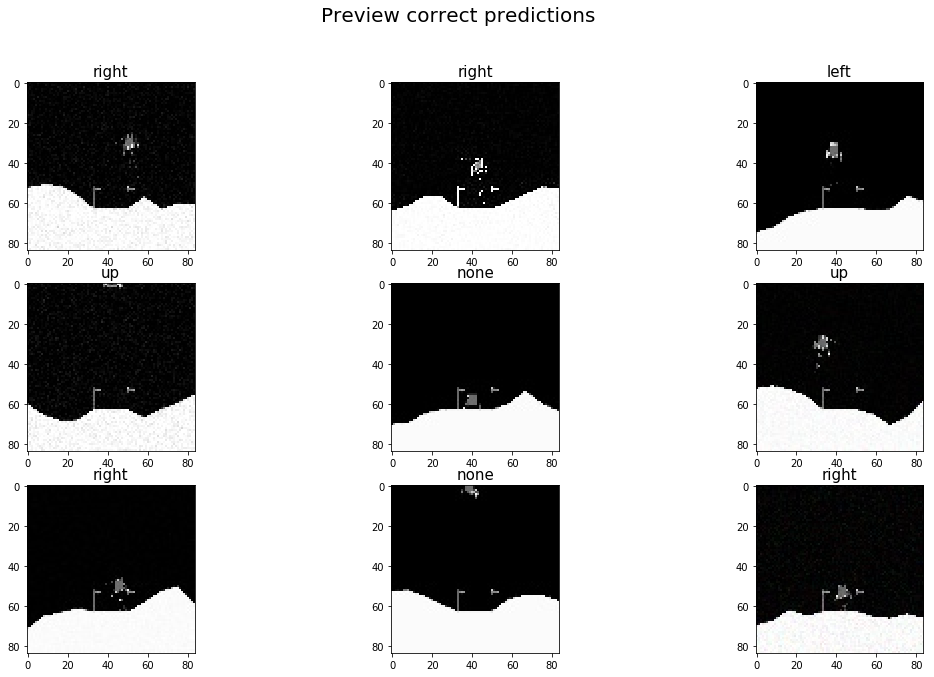

In [28]:
preview_results('correct')

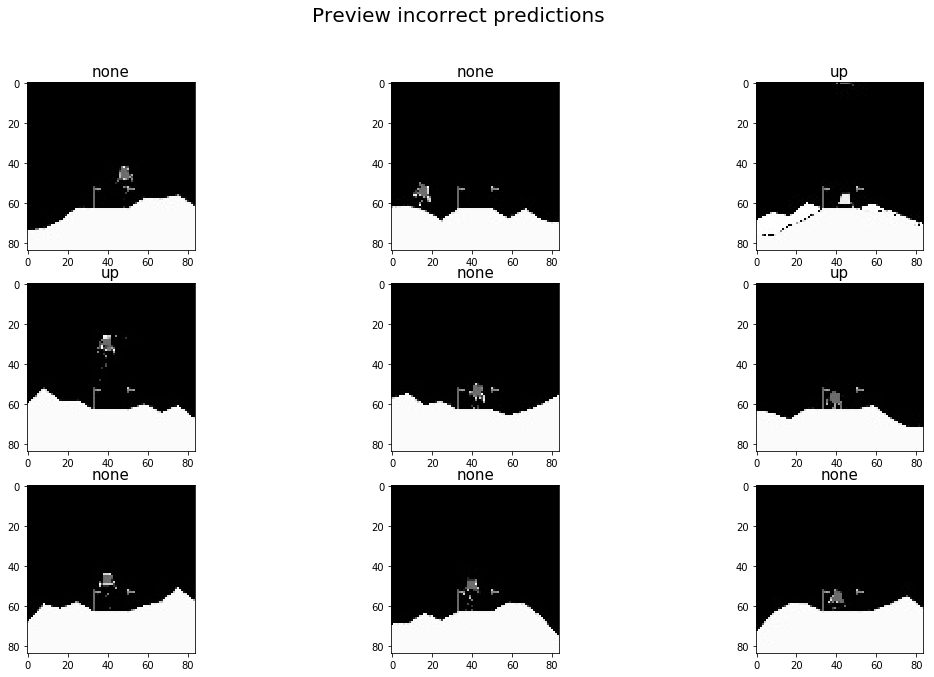

In [29]:
preview_results('incorrect')

# Reinforcement Learning Section

## Instantiate the Lunar Lander environment, build the network and train it. At the end, test the agent with the learnt parameters.

In [3]:
def load_rl_architecture():
    
    ENV_NAME = 'LunarLander-v2'
    
    # Get the environment and extract the number of actions.
    env = gym.make(ENV_NAME)
    np.random.seed(123)
    env.seed(123)
    nb_actions = env.action_space.n

    # Next, we build a very simple model.
    model = Sequential()
    model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
    model.add(Dense(50))
    model.add(Activation('relu'))
    model.add(Dense(30))
    model.add(Activation('relu'))
    model.add(Dense(16))
    model.add(Activation('relu'))
    model.add(Dense(nb_actions))
    model.add(Activation('linear'))
    print(model.summary())

    # Finally, we configure and compile our agent. You can use every built-in Keras optimizer and
    # even the metrics!
    memory = SequentialMemory(limit=50000, window_length=1)
    policy = BoltzmannQPolicy()
    dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=10,
                   target_model_update=1e-2, policy=policy)
    dqn.compile(Adam(lr=1e-3), metrics=['mae'])
    return dqn, env

In [3]:
dqn, env = load_rl_architecture()
ENV_NAME = 'LunarLander-v2'
# Okay, now it's time to learn something! We visualize the training here for show, but this
# slows down training quite a lot. You can always safely abort the training prematurely using
# Ctrl + C.
dqn.fit(env, nb_steps=100000, visualize=True, verbose=2)

# After training is done, we save the final weights.
dqn.save_weights('weights/dqn_{}_weights.h5f'.format(ENV_NAME), overwrite=True)

# Finally, evaluate our algorithm for 50 episodes.
dqn.test(env, nb_episodes=50, visualize=True)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                450       
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1530      
_________________________________________________________________
activation_2 (Activation)    (None, 30)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                496       
_________________________________________________________________
activation_3 (Activation)    (None, 16)                0         
__________

c:\users\ruben\docume~1\ucd\18-19_~2\comp47~1\ml_env\lib\site-packages\rl\memory.py:39: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


    78/100000: episode: 1, duration: 5.240s, episode steps: 78, steps per second: 15, episode reward: -94.585, mean reward: -1.213 [-100.000, 14.080], mean action: 1.705 [0.000, 3.000], mean observation: 0.080 [-1.480, 1.399], loss: 1.655223, mean_absolute_error: 0.478007, mean_q: 0.266833
   160/100000: episode: 2, duration: 1.364s, episode steps: 82, steps per second: 60, episode reward: -367.474, mean reward: -4.481 [-100.000, 0.708], mean action: 1.585 [0.000, 3.000], mean observation: 0.292 [-1.282, 1.806], loss: 43.903004, mean_absolute_error: 1.030369, mean_q: 0.926637
   235/100000: episode: 3, duration: 1.248s, episode steps: 75, steps per second: 60, episode reward: -346.710, mean reward: -4.623 [-100.000, 3.947], mean action: 1.653 [0.000, 3.000], mean observation: 0.022 [-4.779, 1.622], loss: 63.828690, mean_absolute_error: 2.333868, mean_q: -0.083194
   468/100000: episode: 4, duration: 3.881s, episode steps: 233, steps per second: 60, episode reward: -202.234, mean reward

  6245/100000: episode: 28, duration: 4.865s, episode steps: 292, steps per second: 60, episode reward: -82.223, mean reward: -0.282 [-100.000, 16.297], mean action: 1.788 [0.000, 3.000], mean observation: -0.063 [-1.047, 1.396], loss: 7.196392, mean_absolute_error: 22.377464, mean_q: 10.951176
  6697/100000: episode: 29, duration: 7.545s, episode steps: 452, steps per second: 60, episode reward: -100.535, mean reward: -0.222 [-100.000, 14.114], mean action: 1.657 [0.000, 3.000], mean observation: -0.018 [-1.068, 1.398], loss: 8.043255, mean_absolute_error: 22.859884, mean_q: 11.503370
  6981/100000: episode: 30, duration: 4.731s, episode steps: 284, steps per second: 60, episode reward: 12.316, mean reward: 0.043 [-100.000, 10.416], mean action: 1.736 [0.000, 3.000], mean observation: 0.063 [-0.605, 1.427], loss: 4.366754, mean_absolute_error: 23.126850, mean_q: 12.500676
  7549/100000: episode: 31, duration: 9.463s, episode steps: 568, steps per second: 60, episode reward: -125.338, 

 29899/100000: episode: 55, duration: 16.659s, episode steps: 1000, steps per second: 60, episode reward: 64.770, mean reward: 0.065 [-24.557, 23.468], mean action: 1.573 [0.000, 3.000], mean observation: 0.076 [-0.820, 1.398], loss: 4.763743, mean_absolute_error: 25.699661, mean_q: 32.925022
 30899/100000: episode: 56, duration: 16.660s, episode steps: 1000, steps per second: 60, episode reward: 46.098, mean reward: 0.046 [-24.222, 23.515], mean action: 1.676 [0.000, 3.000], mean observation: 0.100 [-0.850, 1.501], loss: 5.559831, mean_absolute_error: 25.943083, mean_q: 33.429527
 31394/100000: episode: 57, duration: 8.245s, episode steps: 495, steps per second: 60, episode reward: -295.099, mean reward: -0.596 [-100.000, 26.963], mean action: 1.717 [0.000, 3.000], mean observation: 0.112 [-0.578, 2.047], loss: 5.847774, mean_absolute_error: 25.885002, mean_q: 33.297169
 32394/100000: episode: 58, duration: 16.661s, episode steps: 1000, steps per second: 60, episode reward: 8.668, mea

 52604/100000: episode: 82, duration: 16.661s, episode steps: 1000, steps per second: 60, episode reward: 134.527, mean reward: 0.135 [-20.403, 22.367], mean action: 1.444 [0.000, 3.000], mean observation: 0.152 [-0.795, 1.405], loss: 4.181297, mean_absolute_error: 27.726768, mean_q: 37.090393
 53604/100000: episode: 83, duration: 16.659s, episode steps: 1000, steps per second: 60, episode reward: 131.825, mean reward: 0.132 [-18.724, 23.505], mean action: 1.291 [0.000, 3.000], mean observation: 0.146 [-1.328, 1.473], loss: 3.741710, mean_absolute_error: 27.135237, mean_q: 36.378647
 54604/100000: episode: 84, duration: 16.659s, episode steps: 1000, steps per second: 60, episode reward: 119.498, mean reward: 0.119 [-22.806, 22.966], mean action: 1.373 [0.000, 3.000], mean observation: 0.177 [-0.473, 1.412], loss: 4.169320, mean_absolute_error: 26.747206, mean_q: 35.857540
 55604/100000: episode: 85, duration: 16.662s, episode steps: 1000, steps per second: 60, episode reward: 122.206, 

 71314/100000: episode: 109, duration: 16.713s, episode steps: 1000, steps per second: 60, episode reward: 158.124, mean reward: 0.158 [-21.639, 23.178], mean action: 1.273 [0.000, 3.000], mean observation: 0.202 [-0.636, 1.408], loss: 3.565037, mean_absolute_error: 27.279211, mean_q: 36.611172
 72314/100000: episode: 110, duration: 16.660s, episode steps: 1000, steps per second: 60, episode reward: 162.600, mean reward: 0.163 [-22.590, 22.570], mean action: 1.388 [0.000, 3.000], mean observation: 0.227 [-0.610, 1.389], loss: 4.038869, mean_absolute_error: 27.308586, mean_q: 36.595741
 73314/100000: episode: 111, duration: 16.725s, episode steps: 1000, steps per second: 60, episode reward: 149.119, mean reward: 0.149 [-19.207, 23.167], mean action: 1.360 [0.000, 3.000], mean observation: 0.171 [-0.847, 1.392], loss: 3.333226, mean_absolute_error: 27.510780, mean_q: 36.949051
 74314/100000: episode: 112, duration: 16.660s, episode steps: 1000, steps per second: 60, episode reward: -20.9

 95079/100000: episode: 136, duration: 16.660s, episode steps: 1000, steps per second: 60, episode reward: 145.230, mean reward: 0.145 [-22.038, 24.887], mean action: 1.513 [0.000, 3.000], mean observation: 0.248 [-0.832, 1.399], loss: 3.077813, mean_absolute_error: 25.480192, mean_q: 34.571125
 96079/100000: episode: 137, duration: 16.659s, episode steps: 1000, steps per second: 60, episode reward: 175.697, mean reward: 0.176 [-20.899, 23.113], mean action: 1.432 [0.000, 3.000], mean observation: 0.221 [-0.810, 1.386], loss: 2.914372, mean_absolute_error: 25.530859, mean_q: 34.514633
 97079/100000: episode: 138, duration: 16.659s, episode steps: 1000, steps per second: 60, episode reward: 142.519, mean reward: 0.143 [-21.448, 23.079], mean action: 1.278 [0.000, 3.000], mean observation: 0.208 [-0.738, 1.396], loss: 3.298617, mean_absolute_error: 25.254799, mean_q: 34.097908
 98079/100000: episode: 139, duration: 16.660s, episode steps: 1000, steps per second: 60, episode reward: 67.71

## It is seems to be doing ok, rewards are mostly postive. 

# ------Comparison section------
## Now, let's compare the performance of each model, that is:

## a) the CNN model trained with a single frame, 
## b) the CNN model trained with a sequence of frames and 
## c) the RL model, 
## and see which one performs better

In [2]:
def test_cnn_model(path_read, path_write, single_frame = True, frames=3):
    """Test CNN model
    path_read: string, path to model
    path_write: string, path to save results in csv format
    single_frame: boolean, defines whether model trained with a single frame or not
    frames: int, defines number of frames to be combined to then feed a model (only implemented when single_frame = False)
    
    NOTE: some modifications on the code below have been implemented, as my CNN training required color 
    images because I implemented a transfer learning strategy (the VGG16 network requires an image 
    shape of (widh, height, channels =3))
    """
    path = path_read
    
    # Load the Lunar Lander environment
    env = ll.LunarLander()

    # Load and initialise the contrll model
    ROWS = 84
    COLS = 84
    CHANNELS = 3
    model = keras.models.load_model(path)

    total_rewards = []

    for i in range(0, 200):
        s = env.reset()

        # Run the game loop
        total_reward = 0
        steps = 0
        while True:
            if not single_frame:
                # set a placeholder to same combined images
                combined_frames = np.zeros(shape=(ROWS, COLS), dtype=np.uint8)
                # read a sequence of frames, combine them and then feed the model with the resulting object
                for j in range(frames):
                    # Access the rendered image
                    raw_image = env.render(mode='rgb_array')
                    # Prepare the image for presentation to the network
                    processed_image = cv2.resize(raw_image, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)
                    # grayscale
                    processed_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2GRAY)
                    # combine images to pass on a "sequence"
                    combined_frames += processed_image
                # back to three channels
                processed_image = cv2.cvtColor(combined_frames, cv2.COLOR_GRAY2RGB)
                # reshape the matrix
                processed_image = processed_image.reshape((1, ROWS, COLS, 3))
            
            # model trained with a single frame
            else:
                raw_image = env.render(mode='rgb_array')
                # Prepare the image for presentation to the network
                processed_image = cv2.resize(raw_image, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)
                # this now reads color images:
                processed_image = cv2.cvtColor(processed_image, 1)
                # changed the order of reshaping:
                processed_image = processed_image.reshape((1, ROWS, COLS, CHANNELS))
                
            processed_image = np.array(processed_image, dtype=np.float)
            #processed_image = processed_image/255
            
            # Get the model to make a prediction
            # NOTE: my model did not have predict_classes method, I am using predict and extracting the action manually 
            a = model.predict(processed_image)
            a = np.argmax(a)

            # Step on the game
            s, r, done, info = env.step(a)
            env.render()
            total_reward += r
            if steps % 20 == 0 or done:
                print(["{:+0.2f}".format(x) for x in s])
                print("step {} total_reward {:+0.2f}".format(steps, total_reward))
                steps += 1
                if done: 
                    total_rewards.append(total_reward)
                    break

    print("total rewards", total_rewards)
    print("average total reward", np.mean(total_rewards))    

    # Write total rewards to file
    pd.DataFrame(total_rewards, columns=['total_rewards']).to_csv(path_write, index=False)

## Test model trained with a single image

In [3]:
test_cnn_model('weights/best_weights.hdf5', 'csv/total_rewards_cnn_single.csv', True)

['-0.00', '+0.92', '-0.13', '-0.54', '+0.00', '-0.01', '+0.00', '+0.00']
step 0 total_reward -1.38
['+1.02', '+0.18', '+2.50', '-0.41', '-0.76', '-0.07', '+0.00', '+0.00']
step 1 total_reward -432.61
['-0.01', '+0.93', '-0.54', '-0.43', '+0.01', '+0.08', '+0.00', '+0.00']
step 0 total_reward -0.30
['-1.02', '+0.21', '-1.66', '-0.09', '+0.48', '+0.13', '+0.00', '+0.00']
step 1 total_reward -276.32
['+0.02', '+0.93', '+0.79', '-0.50', '-0.02', '-0.18', '+0.00', '+0.00']
step 0 total_reward -1.40
['+0.77', '-0.03', '+1.46', '-0.37', '-0.52', '+2.84', '+0.00', '+0.00']
step 1 total_reward -228.61
['+0.01', '+0.94', '+0.44', '+0.06', '-0.01', '-0.13', '+0.00', '+0.00']
step 0 total_reward -1.23
['+1.03', '+0.22', '+2.93', '-0.95', '-1.53', '-0.48', '+0.00', '+0.00']
step 1 total_reward -534.73
['-0.01', '+0.95', '-0.55', '+0.33', '+0.01', '+0.08', '+0.00', '+0.00']
step 0 total_reward +1.50
['+0.75', '+0.03', '+1.18', '+0.82', '-1.64', '-4.78', '+1.00', '+0.00']
step 1 total_reward -454.69


['+0.31', '+0.03', '+1.49', '+0.16', '-2.19', '-1.18', '+1.00', '+0.00']
step 1 total_reward -500.75
['-0.01', '+0.96', '-0.49', '+0.48', '+0.01', '+0.08', '+0.00', '+0.00']
step 0 total_reward +1.34
['+1.00', '+0.24', '+1.02', '-1.74', '-0.56', '-0.88', '+0.00', '+0.00']
step 1 total_reward -346.19
['-0.01', '+0.94', '-0.46', '-0.16', '+0.01', '+0.10', '+0.00', '+0.00']
step 0 total_reward -0.99
['-0.50', '-0.05', '-0.11', '-0.12', '-0.45', '+0.74', '+1.00', '+0.00']
step 1 total_reward -89.59
['+0.00', '+0.95', '+0.05', '+0.19', '-0.00', '-0.05', '+0.00', '+0.00']
step 0 total_reward +1.72
['+0.27', '-0.02', '+1.46', '-0.63', '-1.94', '+4.06', '+1.00', '+0.00']
step 1 total_reward -435.44
['+0.01', '+0.93', '+0.30', '-0.43', '-0.01', '-0.11', '+0.00', '+0.00']
step 0 total_reward -2.60
['+0.45', '-0.14', '+1.19', '-0.47', '-0.40', '+1.55', '+1.00', '+1.00']
step 1 total_reward -170.58
['-0.01', '+0.93', '-0.71', '-0.33', '+0.02', '+0.16', '+0.00', '+0.00']
step 0 total_reward -1.26
[

['+0.01', '+0.94', '+0.51', '-0.02', '-0.01', '-0.16', '+0.00', '+0.00']
step 0 total_reward -2.01
['+0.82', '-0.06', '+0.44', '+0.45', '-1.29', '-1.69', '+1.00', '+0.00']
step 1 total_reward -344.27
['+0.01', '+0.95', '+0.53', '+0.44', '-0.01', '-0.16', '+0.00', '+0.00']
step 0 total_reward -0.58
['+1.00', '+0.10', '+2.18', '-0.88', '-1.59', '-4.37', '+1.00', '+0.00']
step 1 total_reward -433.36
['-0.00', '+0.93', '-0.17', '-0.33', '+0.00', '+0.01', '+0.00', '+0.00']
step 0 total_reward -1.41
['-1.00', '+0.95', '-1.06', '-0.64', '+0.85', '+0.14', '+0.00', '+0.00']
step 1 total_reward -345.54
['+0.01', '+0.95', '+0.32', '+0.36', '-0.01', '-0.11', '+0.00', '+0.00']
step 0 total_reward +0.14
['+0.53', '+0.02', '+0.51', '+0.08', '-0.70', '-1.46', '+1.00', '+0.00']
step 1 total_reward -237.29
['-0.01', '+0.93', '-0.40', '-0.46', '+0.01', '+0.05', '+0.00', '+0.00']
step 0 total_reward -0.69
['-0.95', '-0.05', '-0.15', '+0.06', '+1.87', '+0.51', '+0.00', '+1.00']
step 1 total_reward -304.34


## Test model trained with 5 frames, feeding it 2 frames to infer

In [26]:
test_cnn_model('weights/best_weights_mixed.hdf5', 'csv/total_rewards_cnn_multi2.csv', False, 2)

['+0.01', '+0.94', '+0.34', '+0.06', '-0.01', '-0.08', '+0.00', '+0.00']
step 0 total_reward +0.11
['+0.44', '-0.02', '+0.30', '-0.37', '-0.19', '+3.85', '+1.00', '+0.00']
step 1 total_reward -162.08
['-0.01', '+0.94', '-0.68', '+0.04', '+0.02', '+0.15', '+0.00', '+0.00']
step 0 total_reward -0.55
['-0.69', '-0.02', '-0.69', '+0.17', '+1.84', '+1.16', '+0.00', '+1.00']
step 1 total_reward -347.02
['+0.01', '+0.94', '+0.72', '+0.05', '-0.02', '-0.16', '+0.00', '+0.00']
step 0 total_reward -0.56
['+0.41', '-0.02', '-0.14', '+0.03', '-3.94', '-0.46', '+0.00', '+1.00']
step 1 total_reward -425.93
['+0.01', '+0.95', '+0.40', '+0.21', '-0.01', '-0.09', '+0.00', '+0.00']
step 0 total_reward +0.54
['+0.90', '-0.19', '+1.32', '-0.63', '-0.70', '+3.52', '+1.00', '+0.00']
step 1 total_reward -300.72
['+0.01', '+0.94', '+0.53', '-0.02', '-0.01', '-0.12', '+0.00', '+0.00']
step 0 total_reward -0.52
['+0.46', '+0.02', '-0.17', '-0.33', '-0.19', '+3.91', '+1.00', '+0.00']
step 1 total_reward -127.77


['-1.02', '+0.34', '-1.70', '-0.67', '+0.59', '+0.01', '+0.00', '+0.00']
step 1 total_reward -330.95
['+0.00', '+0.93', '+0.01', '-0.41', '-0.00', '-0.00', '+0.00', '+0.00']
step 0 total_reward -1.95
['+0.40', '-0.03', '+0.36', '-0.76', '-0.05', '+4.29', '+1.00', '+1.00']
step 1 total_reward -181.11
['-0.01', '+0.95', '-0.54', '+0.22', '+0.01', '+0.12', '+0.00', '+0.00']
step 0 total_reward +0.15
['-1.00', '+0.20', '-1.76', '-0.43', '+0.90', '+0.47', '+0.00', '+0.00']
step 1 total_reward -331.04
['+0.00', '+0.95', '+0.08', '+0.40', '-0.00', '-0.02', '+0.00', '+0.00']
step 0 total_reward +1.84
['+0.09', '-0.03', '-0.00', '-0.00', '+0.00', '+0.00', '+1.00', '+1.00']
step 1 total_reward -97.46
['+0.01', '+0.95', '+0.47', '+0.46', '-0.01', '-0.11', '+0.00', '+0.00']
step 0 total_reward +0.64
['+0.67', '-0.05', '+1.25', '-0.91', '-0.39', '+3.22', '+1.00', '+1.00']
step 1 total_reward -217.38
['-0.01', '+0.93', '-0.72', '-0.37', '+0.02', '+0.16', '+0.00', '+0.00']
step 0 total_reward -1.31
[

['+0.00', '+0.93', '+0.01', '-0.21', '-0.00', '-0.04', '+0.00', '+0.00']
step 0 total_reward -2.51
['+1.00', '+0.89', '+1.34', '-0.04', '-0.26', '+0.00', '+0.00', '+0.00']
step 1 total_reward -311.20
['-0.01', '+0.93', '-0.53', '-0.27', '+0.01', '+0.12', '+0.00', '+0.00']
step 0 total_reward -1.25
['-0.72', '+0.05', '-0.78', '-0.16', '-0.09', '-1.64', '+1.00', '+0.00']
step 1 total_reward -117.96
['+0.00', '+0.93', '+0.02', '-0.35', '-0.00', '-0.01', '+0.00', '+0.00']
step 0 total_reward -2.06
['-1.02', '+0.18', '-2.31', '-0.46', '+2.65', '+3.06', '+0.00', '+0.00']
step 1 total_reward -661.95
['+0.01', '+0.95', '+0.41', '+0.47', '-0.01', '-0.05', '+0.00', '+0.00']
step 0 total_reward +1.60
['+0.56', '-0.09', '+0.30', '+0.02', '+0.10', '+0.00', '+1.00', '+1.00']
step 1 total_reward -120.43
['+0.01', '+0.94', '+0.37', '-0.08', '-0.01', '-0.08', '+0.00', '+0.00']
step 0 total_reward -0.72
['+1.02', '+0.40', '+1.91', '-0.01', '-0.52', '-0.06', '+0.00', '+0.00']
step 1 total_reward -339.67


## Test model trained with 5 frames, feeding it 3 frames to infer

In [3]:
test_cnn_model('weights/best_weights_mixed.hdf5', 'csv/total_rewards_cnn_multi3.csv', False, 3)

['-0.01', '+0.93', '-0.55', '-0.37', '+0.01', '+0.12', '+0.00', '+0.00']
step 0 total_reward -1.40
['-1.01', '+0.20', '-1.48', '+0.05', '+0.22', '-0.01', '+0.00', '+0.00']
step 1 total_reward -236.26
['+0.00', '+0.94', '+0.20', '+0.02', '-0.00', '-0.05', '+0.00', '+0.00']
step 0 total_reward +0.22
['+0.21', '-0.03', '+0.48', '-0.06', '-0.18', '+0.06', '+1.00', '+1.00']
step 1 total_reward -150.64
['+0.01', '+0.95', '+0.39', '+0.28', '-0.01', '-0.09', '+0.00', '+0.00']
step 0 total_reward +0.72
['+0.45', '+0.04', '+0.80', '-0.69', '-0.45', '-4.45', '+1.00', '+1.00']
step 1 total_reward -179.29
['+0.00', '+0.95', '+0.05', '+0.15', '-0.00', '-0.04', '+0.00', '+0.00']
step 0 total_reward +1.78
['+1.01', '+0.72', '+1.42', '-0.30', '-0.82', '-0.17', '+0.00', '+0.00']
step 1 total_reward -361.47
['+0.00', '+0.93', '+0.15', '-0.39', '-0.00', '-0.00', '+0.00', '+0.00']
step 0 total_reward -1.57
['+0.30', '+0.02', '-0.07', '-0.29', '+0.16', '+1.79', '+1.00', '+1.00']
step 1 total_reward -86.64
[

['-1.01', '+0.11', '-1.51', '-0.61', '+0.39', '+0.02', '+0.00', '+0.00']
step 1 total_reward -307.00
['+0.01', '+0.94', '+0.53', '-0.04', '-0.01', '-0.12', '+0.00', '+0.00']
step 0 total_reward -0.60
['+1.01', '+0.14', '+1.66', '-0.81', '-0.74', '-0.16', '+0.00', '+0.00']
step 1 total_reward -323.81
['+0.00', '+0.93', '+0.11', '-0.37', '-0.00', '+0.02', '+0.00', '+0.00']
step 0 total_reward -1.41
['-0.01', '-0.02', '-0.31', '-0.43', '+0.20', '-3.12', '+0.00', '+1.00']
step 1 total_reward -87.37
['-0.00', '+0.92', '-0.22', '-0.56', '+0.00', '+0.05', '+0.00', '+0.00']
step 0 total_reward -1.78
['-0.42', '+0.07', '-0.31', '+0.03', '-0.12', '+0.00', '+1.00', '+1.00']
step 1 total_reward -88.86
['+0.02', '+0.94', '+0.79', '-0.16', '-0.02', '-0.14', '+0.00', '+0.00']
step 0 total_reward +0.05
['-0.89', '+0.10', '-2.61', '+0.39', '+1.77', '+0.41', '+0.00', '+0.00']
step 1 total_reward -532.42
['-0.01', '+0.94', '-0.32', '-0.00', '+0.01', '+0.07', '+0.00', '+0.00']
step 0 total_reward -0.24
['

['-0.00', '+0.93', '-0.09', '-0.22', '+0.00', '+0.05', '+0.00', '+0.00']
step 0 total_reward -2.69
['-1.00', '+0.50', '-0.61', '-1.30', '-0.00', '+0.00', '+0.00', '+0.00']
step 1 total_reward -268.53
['-0.01', '+0.95', '-0.63', '+0.32', '+0.01', '+0.14', '+0.00', '+0.00']
step 0 total_reward +0.08
['-1.00', '+0.13', '-1.82', '-0.99', '+1.09', '+0.36', '+0.00', '+0.00']
step 1 total_reward -355.28
['-0.00', '+0.94', '-0.10', '+0.02', '+0.00', '+0.06', '+0.00', '+0.00']
step 0 total_reward -0.58
['-0.01', '-0.03', '+0.10', '-0.47', '-0.03', '+2.59', '+1.00', '+1.00']
step 1 total_reward -71.41
['-0.00', '+0.95', '-0.17', '+0.28', '+0.00', '-0.01', '+0.00', '+0.00']
step 0 total_reward +2.40
['+0.51', '+0.04', '+1.01', '+0.31', '-1.78', '-0.76', '+0.00', '+0.00']
step 1 total_reward -345.67
['+0.01', '+0.95', '+0.59', '+0.32', '-0.01', '-0.13', '+0.00', '+0.00']
step 0 total_reward +0.20
['+1.00', '+0.10', '+1.74', '-1.20', '-1.07', '-0.25', '+0.00', '+0.00']
step 1 total_reward -358.95
[

## Test model trained with 5 frames, feeding it 4 frames to infer 

In [3]:
test_cnn_model('weights/best_weights_mixed.hdf5', 'csv/total_rewards_cnn_multi4.csv', False, 4)

['+0.01', '+0.94', '+0.72', '-0.09', '-0.02', '-0.16', '+0.00', '+0.00']
step 0 total_reward -0.86
['+0.72', '-0.15', '+1.28', '-0.97', '-0.49', '+4.76', '+1.00', '+0.00']
step 1 total_reward -243.16
['-0.01', '+0.94', '-0.66', '-0.11', '+0.01', '+0.15', '+0.00', '+0.00']
step 0 total_reward -0.87
['-1.01', '+0.51', '-1.34', '+0.02', '+0.10', '+0.03', '+0.00', '+0.00']
step 1 total_reward -213.38
['+0.01', '+0.95', '+0.47', '+0.19', '-0.01', '-0.11', '+0.00', '+0.00']
step 0 total_reward +0.24
['+0.88', '+0.03', '+0.15', '-0.17', '-1.97', '-3.45', '+0.00', '+0.00']
step 1 total_reward -414.73
['-0.01', '+0.93', '-0.36', '-0.32', '+0.01', '+0.04', '+0.00', '+0.00']
step 0 total_reward -0.56
['+1.00', '+0.83', '+1.33', '-0.78', '-0.79', '-0.11', '+0.00', '+0.00']
step 1 total_reward -351.73
['-0.01', '+0.94', '-0.36', '+0.07', '+0.01', '+0.08', '+0.00', '+0.00']
step 0 total_reward +0.11
['-1.01', '+0.57', '-1.76', '+0.36', '+0.75', '+0.25', '+0.00', '+0.00']
step 1 total_reward -361.81


['+1.00', '+0.80', '+2.41', '+0.30', '-0.54', '-0.05', '+0.00', '+0.00']
step 1 total_reward -426.48
['+0.00', '+0.95', '+0.12', '+0.39', '-0.00', '+0.00', '+0.00', '+0.00']
step 0 total_reward +2.17
['+1.01', '+0.46', '+1.42', '-0.18', '-0.32', '-0.03', '+0.00', '+0.00']
step 1 total_reward -270.62
['-0.01', '+0.93', '-0.59', '-0.49', '+0.01', '+0.13', '+0.00', '+0.00']
step 0 total_reward -1.48
['-1.01', '+0.05', '-1.66', '-0.65', '+0.45', '+0.11', '+0.00', '+0.00']
step 1 total_reward -268.56
['+0.00', '+0.94', '+0.24', '+0.06', '-0.01', '-0.05', '+0.00', '+0.00']
step 0 total_reward +0.44
['-0.17', '-0.00', '-1.26', '+0.10', '+1.88', '+1.18', '+0.00', '+1.00']
step 1 total_reward -312.91
['-0.01', '+0.95', '-0.26', '+0.40', '+0.01', '+0.06', '+0.00', '+0.00']
step 0 total_reward +1.29
['-1.01', '+0.57', '-2.03', '+0.44', '+0.70', '+0.27', '+0.00', '+0.00']
step 1 total_reward -375.24
['-0.01', '+0.96', '-0.69', '+0.49', '+0.01', '+0.12', '+0.00', '+0.00']
step 0 total_reward +0.94


['+0.01', '+0.95', '+0.35', '+0.32', '-0.01', '-0.11', '+0.00', '+0.00']
step 0 total_reward +0.00
['+0.57', '+0.17', '+1.16', '-0.20', '-1.69', '+3.09', '+0.00', '+0.00']
step 1 total_reward -387.31
['+0.00', '+0.95', '+0.25', '+0.28', '-0.01', '-0.06', '+0.00', '+0.00']
step 0 total_reward +1.28
['+0.43', '+0.07', '+0.69', '-0.01', '-0.01', '+0.00', '+1.00', '+1.00']
step 1 total_reward -114.65
['+0.01', '+0.94', '+0.35', '+0.13', '-0.01', '-0.08', '+0.00', '+0.00']
step 0 total_reward +0.41
['+0.72', '-0.03', '+1.04', '-0.72', '-0.02', '-5.45', '+0.00', '+1.00']
step 1 total_reward -278.56
['-0.01', '+0.93', '-0.33', '-0.30', '+0.01', '+0.07', '+0.00', '+0.00']
step 0 total_reward -1.58
['-0.91', '-0.05', '-1.46', '-0.82', '+0.70', '-0.00', '+0.00', '+1.00']
step 1 total_reward -312.09
['+0.01', '+0.95', '+0.45', '+0.37', '-0.01', '-0.10', '+0.00', '+0.00']
step 0 total_reward +0.65
['+0.98', '+0.04', '+1.41', '-0.38', '-0.50', '+2.95', '+0.00', '+0.00']
step 1 total_reward -285.66


## Test model trained with 5 frames, feeding it 5 frames to infer

In [3]:
test_cnn_model('weights/best_weights_mixed.hdf5', 'csv/total_rewards_cnn_multi5.csv', False, 5)

['+0.01', '+0.94', '+0.32', '-0.11', '-0.01', '-0.04', '+0.00', '+0.00']
step 0 total_reward -0.04
['-0.93', '-0.06', '-2.15', '+0.25', '+1.74', '+0.00', '+0.00', '+1.00']
step 1 total_reward -527.17
['-0.01', '+0.93', '-0.59', '-0.44', '+0.02', '+0.17', '+0.00', '+0.00']
step 0 total_reward -2.46
['-1.00', '+0.18', '-2.10', '-0.51', '+0.55', '+0.03', '+0.00', '+0.00']
step 1 total_reward -320.67
['-0.01', '+0.95', '-0.45', '+0.28', '+0.01', '+0.07', '+0.00', '+0.00']
step 0 total_reward +1.41
['+0.17', '+0.00', '+1.71', '-0.96', '-2.95', '-8.25', '+0.00', '+0.00']
step 1 total_reward -536.00
['-0.00', '+0.94', '-0.01', '+0.01', '+0.00', '+0.04', '+0.00', '+0.00']
step 0 total_reward +1.90
['-1.00', '+0.59', '-2.55', '+0.15', '+0.83', '+0.15', '+0.00', '+0.00']
step 1 total_reward -477.06
['+0.01', '+0.94', '+0.59', '-0.01', '-0.01', '-0.13', '+0.00', '+0.00']
step 0 total_reward -0.56
['-1.01', '+0.83', '-2.92', '+0.31', '+0.98', '+0.16', '+0.00', '+0.00']
step 1 total_reward -494.63


['+0.81', '+0.08', '+1.13', '+0.42', '-1.86', '-3.89', '+0.00', '+0.00']
step 1 total_reward -551.80
['+0.01', '+0.94', '+0.58', '+0.02', '-0.01', '-0.13', '+0.00', '+0.00']
step 0 total_reward -0.46
['+1.00', '+0.34', '+1.61', '-0.48', '-0.54', '-0.14', '+0.00', '+0.00']
step 1 total_reward -287.46
['+0.01', '+0.92', '+0.73', '-0.57', '-0.02', '-0.16', '+0.00', '+0.00']
step 0 total_reward -1.45
['+1.01', '+0.29', '+1.86', '-0.28', '-0.59', '-0.12', '+0.00', '+0.00']
step 1 total_reward -281.85
['-0.01', '+0.93', '-0.57', '-0.51', '+0.01', '+0.13', '+0.00', '+0.00']
step 0 total_reward -1.50
['-1.03', '+0.11', '-2.83', '-0.97', '+1.43', '+0.43', '+0.00', '+0.00']
step 1 total_reward -484.33
['+0.01', '+0.94', '+0.57', '-0.11', '-0.01', '-0.16', '+0.00', '+0.00']
step 0 total_reward -2.00
['+1.01', '+0.02', '+1.21', '-0.25', '-1.96', '-5.19', '+1.00', '+0.00']
step 1 total_reward -348.05
['-0.00', '+0.94', '-0.20', '-0.10', '+0.01', '+0.09', '+0.00', '+0.00']
step 0 total_reward -2.45


['-0.01', '+0.92', '-0.44', '-0.58', '+0.01', '+0.10', '+0.00', '+0.00']
step 0 total_reward -1.61
['-0.65', '-0.21', '-1.28', '-0.29', '+0.18', '-0.95', '+1.00', '+1.00']
step 1 total_reward -173.61
['-0.01', '+0.93', '-0.30', '-0.33', '+0.01', '+0.07', '+0.00', '+0.00']
step 0 total_reward -1.66
['-1.00', '+0.07', '-1.93', '-0.66', '+0.80', '+0.26', '+0.00', '+0.00']
step 1 total_reward -359.89
['-0.00', '+0.95', '-0.21', '+0.25', '+0.00', '+0.00', '+0.00', '+0.00']
step 0 total_reward +2.37
['+0.41', '-0.05', '+1.77', '-0.01', '-2.35', '-2.55', '+1.00', '+0.00']
step 1 total_reward -470.93
['-0.00', '+0.93', '-0.15', '-0.44', '+0.00', '+0.06', '+0.00', '+0.00']
step 0 total_reward -2.36
['-1.02', '+0.14', '-2.88', '-0.76', '+1.44', '+0.39', '+0.00', '+0.00']
step 1 total_reward -520.31
['-0.00', '+0.93', '-0.13', '-0.51', '+0.00', '+0.03', '+0.00', '+0.00']
step 0 total_reward -1.86
['-1.01', '+0.96', '-1.12', '-0.33', '+1.65', '+0.54', '+0.00', '+0.00']
step 1 total_reward -403.63


## Apparently, it did not do very well... Now lest's test the RL model:

In [8]:
def test_rl_model(path_write):
    
    dqn, env = load_rl_architecture()
    
    ENV_NAME = 'LunarLander-v2'
    # After training is done, we save the final weights.
    dqn.load_weights('weights/dqn_{}_weights.h5f'.format(ENV_NAME))

    # Redirect stdout to capture test results
    old_stdout = sys.stdout
    sys.stdout = mystdout = io.StringIO()

    # Evaluate our algorithm for a few episodes.
    dqn.test(env, nb_episodes=200, visualize=False)

    # Reset stdout
    sys.stdout = old_stdout

    results_text = mystdout.getvalue()

    # Print results text
    print("results")
    print(results_text)

    # Extact a rewards list from the results
    total_rewards = list()
    for idx, line in enumerate(results_text.split('\n')):
        if idx > 0 and len(line) > 1:
            reward = float(line.split(':')[2].split(',')[0].strip())
            total_rewards.append(reward)

    # Print rewards and average	
    print("total rewards", total_rewards)
    print("average total reward", np.mean(total_rewards))

    # Write total rewards to file
    pd.DataFrame(total_rewards, columns=['total_rewards']).to_csv(path_write, index=False)

In [9]:
test_rl_model('csv/total_rewards_rl.csv')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 8)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                450       
_________________________________________________________________
activation_5 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 30)                1530      
_________________________________________________________________
activation_6 (Activation)    (None, 30)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                496       
_________________________________________________________________
activation_7 (Activation)    (None, 16)                0         
__________


total rewards [219.153, 166.51, 266.119, 227.089, 258.633, 135.572, 140.686, 189.608, 240.697, 140.898, 160.505, 237.987, 217.463, 234.916, 260.152, 245.117, 124.891, 159.092, 230.486, 132.197, 243.905, 111.498, 136.719, 127.297, 139.298, 241.274, 250.29, 119.206, 210.798, 129.023, 264.661, 213.194, 153.118, 258.895, 143.29, 249.713, 232.084, 135.741, 150.57, 266.216, 274.241, 264.066, 113.229, 120.937, 267.269, 145.203, 170.078, 234.344, 176.018, 254.139, 227.608, 130.517, 135.777, 246.988, 132.186, 160.685, 227.856, 223.777, 233.604, 226.882, 116.718, 222.959, 227.326, 252.507, 243.967, 147.695, 244.034, 122.065, 196.548, 161.049, 158.887, 218.071, 135.514, 114.051, 218.515, 269.828, 204.227, 145.54, 157.584, 110.929, 235.448, 237.522, 136.662, 131.368, 223.492, 160.442, 119.872, 141.527, 241.581, 229.512, 253.432, 149.47, 37.354, 239.786, 239.03, 114.412, 233.919, 187.111, 159.019, 281.608, 72.914, 142.076, 116.147, 185.129, 114.767, 250.823, 87.921, 229.138, -781.948, 145.395, 228

## It did much better, ~181 total averaged reward, let's compare episode by episode.

## Finally let's compare the results!!

In [10]:
def compare_results(path_read, path_write):
    
    rl_results = pd.read_csv(os.path.join(path_read,'total_rewards_rl.csv'))
    cnn_results_s = pd.read_csv(os.path.join(path_read,'total_rewards_cnn_single.csv'))
    cnn_results_m2 = pd.read_csv(os.path.join(path_read,'total_rewards_cnn_multi2.csv'))
    cnn_results_m3 = pd.read_csv(os.path.join(path_read,'total_rewards_cnn_multi3.csv'))
    cnn_results_m4 = pd.read_csv(os.path.join(path_read,'total_rewards_cnn_multi4.csv'))
    cnn_results_m5 = pd.read_csv(os.path.join(path_read,'total_rewards_cnn_multi5.csv'))
    
    mean_rl = [np.sum(rl_results)/len(rl_results)]*len(rl_results)
    mean_cnn_s = [np.sum(cnn_results_s)/len(cnn_results_s)]*len(cnn_results_s)
    mean_cnn_m2 = [np.sum(cnn_results_m2)/len(cnn_results_m2)]*len(cnn_results_m2)
    mean_cnn_m3 = [np.sum(cnn_results_m3)/len(cnn_results_m3)]*len(cnn_results_m3)
    mean_cnn_m4 = [np.sum(cnn_results_m4)/len(cnn_results_m4)]*len(cnn_results_m4)
    mean_cnn_m5 = [np.sum(cnn_results_m5)/len(cnn_results_m5)]*len(cnn_results_m5)
    
    fig = plt.figure()
    fig.set_size_inches(18.5, 10.5)
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.plot(rl_results, 'blue', label='RL reward')
    plt.plot(cnn_results_s, 'green', label='CNN single reward')
    plt.plot(cnn_results_m2, 'red', label='CNN multi 2 reward')
    plt.plot(cnn_results_m3, 'yellow', label='CNN multi 3 reward')
    plt.plot(cnn_results_m4, 'pink', label='CNN multi 4 reward')
    plt.plot(cnn_results_m5, 'black', label='CNN multi 5 reward')
    plt.plot(mean_rl, label='RL avg reward')
    plt.plot(mean_cnn_s, label='CNN single avg reward')
    plt.plot(mean_cnn_m2, label='CNN multi 2 avg reward')
    plt.plot(mean_cnn_m3, label='CNN multi 3 avg reward')
    plt.plot(mean_cnn_m4, label='CNN multi 4 avg reward')
    plt.plot(mean_cnn_m5, label='CNN multi 5 avg reward')
    plt.xticks(range(0,200)[0::10])
    plt.legend()
    plt.savefig(path_write, dpi=300)
    

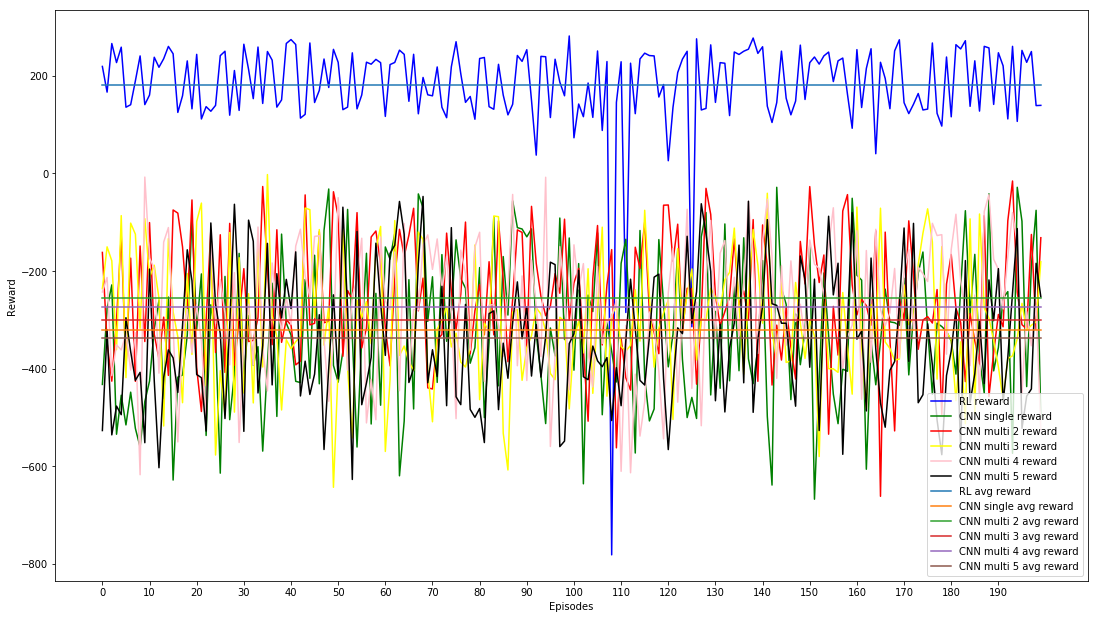

In [11]:
compare_results('csv/','results.png')

# Conclusions:

# Surprisingly enough, we can clearly see how the RL strategy out performs the CNN strategy by a huge margin. In retrospective it makes sense, as the CNN learnt a classification function and not to maximize the landing objective. If dig a little bit deeper, the idea of using a classifier to determine the actions in the openAI environment causes issues such as a positive feedback loop, to put it in an example: the CNN sees the frame and classifies it as an "UP", this "UP" is taken by the ENV an "UP" action is produced, then the next frame is a consequence of the action taken, then the classifier is most likely to see the current frame and say it is "UP" again, producing a positive feedback loop. Even if we had a nearly perfect classifier I believe this strategy would not work. Another issue in terms of classification is that the frames were recorded from an expert playing, meaning that our example distribution is small and not representative of the whole space, so a question arises with this: what happens when the ship goes to somewhere on the screen that it has never seen before? In these cases I believe the classifier is most likely to fail making the situation even worst.
# Another thing that captured my interest was the disk space each of the models required, RL = 33 kb, CNN = 68 Mb, very impressive, we can see here how different architectures/strategies work better for the tasks they were actually built to work with. On top of this, the training for the CNN with 100 epochs took around three hours to finish, at the end I changed this to 25 epochs as I noticed that from there on classification accuracy increased very little, I also added a couple of layers to the head of the CNN architecture and reduced the number of neurons from 256 to 100 and 50 as the images are not that complex. Having said that the RL algorithm took around 20 minutes and the results were amazing.


